In [2]:
import sys
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
import math
sys.path.append('../')
from model import Model, feedforward_signal, feedback_signal
from image_generation import generate_block
from scipy import signal, ndimage
from copy import deepcopy
from utils import extract_window, gaussian_1d, gaussian_kernel, runge_kutta2_step

from scipy import signal, ndimage, interpolate
from functools import partial
import cProfile
from pathlib import Path

import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
cmap='plasma'
np.set_printoptions(precision=4)

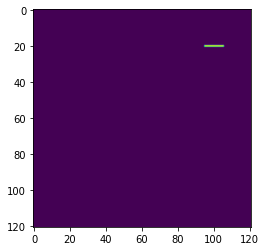

In [14]:
def generate_block(input_dim: int = 121,
                   figure_dim = (25, 25),
                   midpoint = None,
                   figure_orientation: float = 1,
                   bg_orientation: float = 0) -> np.ndarray:
    image = []
    if midpoint is None:
        midpoint = (input_dim / 2, input_dim / 2)
    for x in range(input_dim):
        row = []
        for y in range(input_dim):
            if (midpoint[0] - figure_dim[0] / 2) <= x <= (midpoint[0] + figure_dim[0] / 2) \
                    and (midpoint[1] - figure_dim[1] / 2) <= y <= (midpoint[1] + figure_dim[1] / 2):
                row.append(figure_orientation)
            else:
                row.append(bg_orientation)
        image.append(row)
    return np.array(image, dtype='float32')

plt.imshow(generate_block(figure_dim=(1,10), midpoint=(20,100)))

In [ ]:
%matplotlib inline
parm_df = pd.read_csv("../parameters.csv", index_col=0)

sigma = 30
exps = {"20°": [115,135], "40°": [95, 135]}#, "60°": [75, 135]} #, "75°": [75, 135], "90°": [75, 135]}
results = {k: {"bck": [], "cen": [], "full": []} for k in exps.keys()}

for exp, orientations in exps.items():
    bg = orientations[1]
    fg = orientations[0]

    model = Model(parm_df, features=[bg, fg], similarity_width=sigma)
    na = generate_block(bg_orientation=bg, figure_orientation=fg, figure_dim=(1,10))

    n = 600
    empty = np.full_like(na, -1)
    for i in range(n):
        if i < 39:  
            model.update(empty, 10e-3)
        else: 
            model.update(na, 10e-3)

        results[exp]["bck"].append(np.mean( np.array([ model.V4[f].V[model.V4[f].bck_x, model.V4[f].bck_y] for f in range(len(model.features))]), axis=0 ))
        results[exp]["cen"].append(np.mean( np.array([ model.V4[f].V[model.V4[f].brd_x, model.V4[f].brd_y] for f in range(len(model.features))]), axis=0 ))
        results[exp]["full"].append(np.mean( np.array([ model.V4[f].V for f in range(len(model.features))]), axis=0 ))

plt.imshow(na)

In [18]:
model.V4[0].cen_x

7

In [ ]:
%matplotlib inline


f, axs = plt.subplots(1,len(exps.keys()), figsize=(20,5))

for i in range(len(exps.keys())):
    exp = list(exps.keys())[i]
    maxV4 = np.amax([results[exp]["bck"], results[exp]["cen"]])
    axs[i].plot(results[exp]["bck"] / maxV4, 'k', label="background")
    axs[i].plot(results[exp]["cen"] / maxV4, 'r', label="center")
    axs[i].title.set_text(f"Activity for orientation difference of {exp}")
    axs[i].legend()





In [ ]:
f, axs = plt.subplots(1,2, figsize=(20,5))

exps_colours = ['b', 'g', 'm', 'y', 'k']

for i in range(len(exps.keys())):
    exp = list(exps.keys())[i]
    maxV4 = np.amax([results[exp]["bck"], results[exp]["cen"]])
    diff = results[exp]["cen"] / maxV4 - results[exp]["bck"] / maxV4
    axs[0].plot(diff, exps_colours[i], label=exp)
    axs[0].legend()
    axs[0].title.set_text("Activity difference figure - bg")
    
    axs[1].plot(np.cumsum(diff), exps_colours[i], label=exp)
    axs[1].legend()
    axs[1].title.set_text("Cumulative Activity difference figure - bg")



In [101]:
plt.imshow()

60

<IPython.core.display.Javascript object>


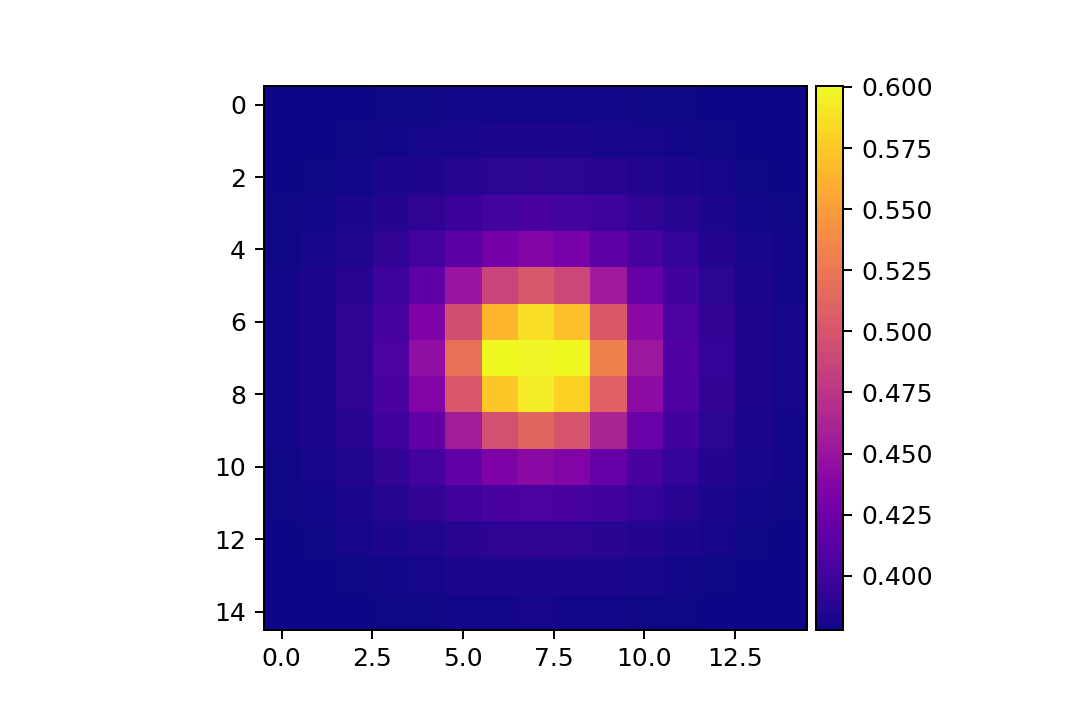

(15, 15)


In [17]:
%matplotlib notebook
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame

activity = np.array(results["40°"]["full"])
fig, ax = plt.subplots()
ims = []
for i in range(600):
    im = ax.imshow(activity[i], cmap=cmap, animated=True)
    if i == 0:
        print(activity[i].shape)
        ax.imshow(activity[i], cmap=cmap)  # show an initial one first
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
writergif = animation.PillowWriter(fps=30)
ani.save('1°.gif',writer=writergif)

plt.show()

0.9877294789470218


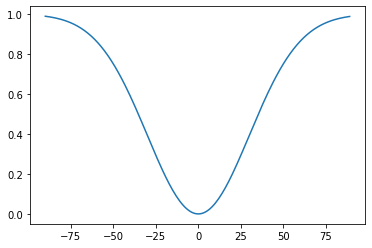

In [88]:

fn = 1-gaussian_1d(np.arange(-90,90), 0, sigma)
plt.plot(np.arange(-90,90), fn)
print(fn[len(fn)-1])

In [24]:
# model = Model(parm_df, features=[0, 1])
n = 600
# LGN = {}
# for f in range(len(model.features)):
#     LGN[f] = []
# LGN["mean"] = []
empty = np.full_like(na, -1)
for i in range(n):

#     for f in range(len(model.features)):
#         model.LGN[f].update(na, 10e-3)
# #         LGN[f].append(model.LGN[f].V)
#         LGN[f].append(model.LGN[f].W)

# #     LGN["mean"].append(np.mean( np.array([ model.LGN[f].V for f in range(len(model.features))]), axis=0 ))
#     LGN["mean"].append(np.mean( np.array([ model.LGN[f].W for f in range(len(model.features))]), axis=0 ))
    if i < 39:
#         if i%10 == 0:
#           print(f"{i}: empty")  
        model.update(empty, 10e-3)
    else:
#         if i%10 == 0:
#           print(f"{i}: image")  
        model.update(na, 10e-3)
        
#     for f in range(len(model.features)):
#         LGN[f].append(model.LGN[f].V)
#         V1[f].append(model.V1[f].V)
#         V2[f].append(model.V2[f].V)
#         V4[f].append(model.V4[f].V)

        
#     LGN["mean"].append(np.mean( np.array([ model.LGN[f].V for f in range(len(model.features))]), axis=0 ))
#     V1["mean"].append(np.mean( np.array([ model.V1[f].V for f in range(len(model.features))]), axis=0 ))
#     V2["mean"].append(np.mean( np.array([ model.V2[f].V for f in range(len(model.features))]), axis=0 ))
    V4["mean"]["bck"].append(np.mean( np.array([ model.V4[f].V[model.V4[f].bck_x, model.V4[f].bck_y] for f in range(len(model.features))]), axis=0 ))
    V4["mean"]["cen"].append(np.mean( np.array([ model.V4[f].V[model.V4[f].cen_x, model.V4[f].cen_y] for f in range(len(model.features))]), axis=0 ))



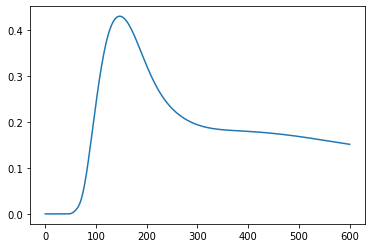

In [5]:
plt.plot(act_v4[1] / maxV4 - act_v4[0] / maxV4)

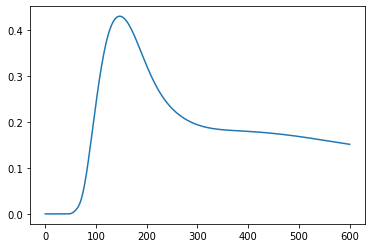

In [6]:
plt.plot(act_v4[1] / maxV4 - act_v4[0] / maxV4)

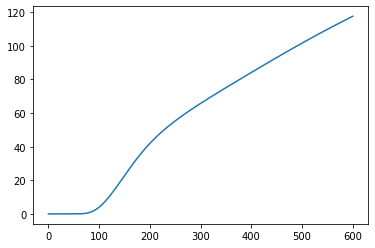

In [7]:
diff = act_v4[1] / maxV4 - act_v4[0] / maxV4
plt.plot(np.cumsum(diff))

In [64]:
V2_ff = []
for f in range(2):
#     _f = interpolate.interp2d(model.V4_X, model.V4_Y, model.V4[f].W)
# #     g = interpolate.interp2d(model.V4_X, model.V4_Y, model.V4[f].W)
#     fb = _f(model.V2_X, model.V2_Y) #+ g(model.V1_X, model.V1_Y)
#     V2_ff.append(ndimage.correlate(fb, model.V2[0].fb_kernel, mode='nearest'))
    V1_2_feedback = feedback_signal(model.V2[f].W,
                                            model.V1[f].fb_kernel,
                                            model.V1_X,
                                            model.V1_Y,
                                            model.V2_X,
                                            model.V2_Y)
    V1_4_feedback = feedback_signal(model.V4[f].W,
                                            model.V1[f].fb_kernel,
                                            model.V1_X,
                                            model.V1_Y,
                                            model.V4_X,
                                            model.V4_Y)
    V2_ff.append(V1_2_feedback + V1_4_feedback)
#     ndimage.correlate(lower_activity_map, kernel, mode='nearest')
#     activity = ndimage.correlate(model.V2[f].V, model.V4[f].ff_kernel, mode='nearest')
#     f = interpolate.interp2d(np.linspace(-1, 1, 61), np.linspace(-1, 1, 61), activity)
#     V2_ff.append(f(np.linspace(-1, 1, 15), np.linspace(-1, 1, 15)))
model.V4[0].V[3,3]
# sum(np.sum(V2_ff[i]) for i in range(2))
# print(model.V4_Y.shape)

0.40643673431876365

In [193]:
print(model.LGN[0].V[44,44] * 1000)
print(model.LGN[0].feature_pref)

0.0
0


In [80]:
# for _ in range(10):
model = Model(parm_df, features=[0, 1])
n = 2
for _ in range(n):
    for i in {0,1}:
        model.LGN[i].update(na, 10e-3) 
        model.V1[i].update(model.LGN[i].V, 10e-3)
# model.update(na, 10e-3)


# print(model.V1[0].V[44,44] * 1000)
# print(np.sum(model.V1[1].V))
# print(ndimage.correlate(model.V1[0].V, gaussian_kernel(9,2), mode='nearest')[44,44]*1000)
print(model.V2[0].D[44,44] * 1000) 

0.0


In [50]:
def wd(V, _input, io):
    return - 2*model.V1[io].D*V \
        - 1/15*ndimage.correlate(abs(_input-ndimage.correlate(_input, gaussian_kernel(9,2), mode='nearest')), \
        gaussian_kernel(5,1), mode='nearest')*(V - 35)

io = 0
vv = runge_kutta2_step(partial(model.V1[io].V_dot), model.LGN[io].V, 10e-3, model.V1[io].V) 
new_w = runge_kutta2_step(partial(wd, io=io), model.V1[io].V, 10e-3, model.V1[io].W)        
new_w[44,44] * 1000

0.0024420005245099894

In [63]:
def vd(V, _input, io):
    return  - 45*model.V1[io].U*(V + 0) \
            - 5*_input*(1 + 2*model.V1[io].D)*(V - 5) \
            - 1*model.V1[io].W*(V - 1)

io = 0
# runge_kutta2_step(partial(vd, io=io), model.LGN[io].V, 10e-3, model.V1[io].V)        

def V_dot(V: np.ndarray, feedforward_signal: np.ndarray, io) -> np.ndarray:
    leak_conductance = -45 * model.V1[io].U * V  # - 45*opt.U.*(V + 0) ...
    driving_input = -5 * feedforward_signal  # - 5*opt.Gin.

        # There is no effect of D cell in V4 so do not compute for that case
#         if not pd.isna(self.k):
    modulated_driving_input = driving_input * (1 + 2 * model.V1[io].D) * (V - 5)  # *(1 + 2*D).*(V - 5) ...
#         else:
#             modulated_driving_input = driving_input * (V - self.e1)  # *(V - 5)
    boundary_detection = -1 * model.V1[io].W * (V - 1)  # - 1*opt.W.*(V - 1)
    return leak_conductance + modulated_driving_input + boundary_detection

# runge_kutta2_step(partial(V_dot, io=io), model.LGN[io].V, 10e-3, model.V1[io].V) 

runge_kutta2_step(partial(model.V1[io].V_dot), model.LGN[io].V, 10e-3, model.V1[io].V) 

#         leak_conductance = -self.g1 * self.U * V  # - 45*opt.U.*(V + 0) ...
#         driving_input = -self.a * feedforward_signal  # - 5*opt.Gin.

#         # There is no effect of D cell in V4 so do not compute for that case
#         if not pd.isna(self.k):
#             modulated_driving_input = driving_input * (1 + self.k * self.D) * (V - self.e1)  # *(1 + 2*D).*(V - 5) ...
#         else:
#             modulated_driving_input = driving_input * (V - self.e1)  # *(V - 5)
#         boundary_detection = -self.g2 * self.W * (V - self.e2)  # - 1*opt.W.*(V - 2)

array([[0.0248, 0.0248, 0.0248, ..., 0.0248, 0.0248, 0.0248],
       [0.0248, 0.0248, 0.0248, ..., 0.0248, 0.0248, 0.0248],
       [0.0248, 0.0248, 0.0248, ..., 0.0248, 0.0248, 0.0248],
       ...,
       [0.0248, 0.0248, 0.0248, ..., 0.0248, 0.0248, 0.0248],
       [0.0248, 0.0248, 0.0248, ..., 0.0248, 0.0248, 0.0248],
       [0.0248, 0.0248, 0.0248, ..., 0.0248, 0.0248, 0.0248]])

In [18]:
 # X = odeSolveHeun(f, X, opt)  function, activity, region
    # X1 = f(X, opt);
    # X = X + opt.dt / 2 * (X1 + f(X + opt.dt * X1, opt));
#     areaLGNExc.f = @(V,opt) ...
#         - 2*opt.W.^2.*V ...
#         - opt.Gin.*(V - 10);

#         areaLGNExc.Gin = squeeze(StimulusSeq(:,:,:,IndexSeq(iter)));
#         areaLGNExc.W = areaLGNInh.V;
#         areaLGNExc = updateNeuronField(areaLGNExc);
lV = [np.zeros_like(na) for _ in range(2)]
lW = [np.zeros_like(na) for _ in range(2)]
_inp = np.array([np.ones_like(na) * (na == 1), np.ones_like(na) * (na == 0)])
for i in range(2):
    lV[i] = (-2 * lW[i]**2 * lV[i]) - (_inp[i] * (lV[i] - 10))

sum(np.sum(lV[i]) for i in range(2))


146410.0

In [52]:
np.argwhere(na == 135)

array([[48, 48],
       [48, 49],
       [48, 50],
       ...,
       [72, 70],
       [72, 71],
       [72, 72]])

In [137]:
activity[61,8,8]

0.05490756762165688

(100, 120)


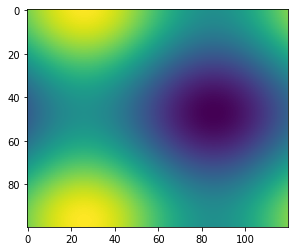

In [86]:

fig, ax = plt.subplots()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = ax.imshow(f(x, y), animated=True)
    if i == 0:
        print(f(x,y).shape)
        ax.imshow(f(x, y))  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.show()

TypeError: Invalid shape () for image data

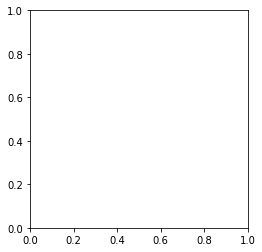

In [133]:
%matplotlib inline
plt.imshow(activity[3])

<IPython.core.display.Javascript object>


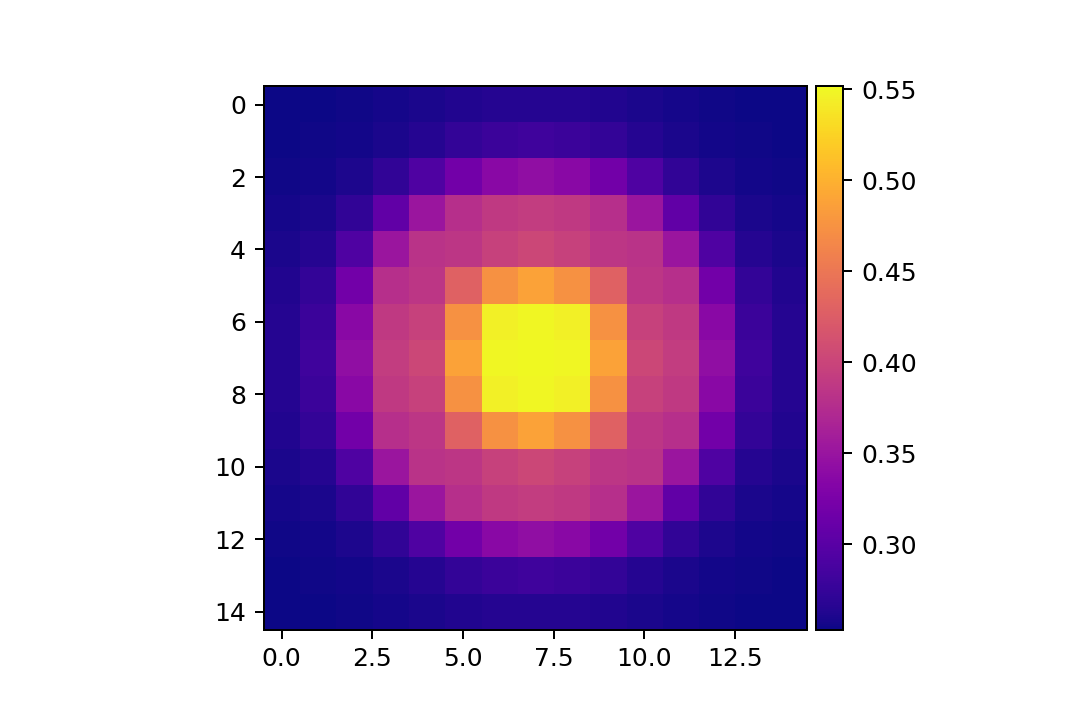

(15, 15)


In [10]:
%matplotlib notebook
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame

activity = np.array(V4["mean"])
fig, ax = plt.subplots()
ims = []
for i in range(600):
    im = ax.imshow(activity[i], cmap=cmap, animated=True)
    if i == 0:
        print(activity[i].shape)
        ax.imshow(activity[i], cmap=cmap)  # show an initial one first
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
writergif = animation.PillowWriter(fps=30)
ani.save('V4[mean].gif',writer=writergif)

plt.show()

In [12]:
20*8

160

In [8]:
# np.argwhere(np.diff(act_v4[0]) > 0)
# The blip happens from 102 to 120

# f, axs = plt.subplots(1,4, figsize=(20,10))
mean_act_v1 = np.array(V1["mean"])
mean_act_v4 = np.array(V4["mean"])
act_v4 = np.array([mean_act_v4[:,model.V4[0].bck_y, model.V4[0].bck_x],
                  mean_act_v4[:,60, 60]])
print(act_v4.shape)
maxV4 = np.amax(act_v4)
f, axs = plt.subplots(1,1)#, figsize=(20,10))
# plt.plot(act_v4.T / maxV4)
axs.plot(act_v4[0] / maxV4, 'k')
axs.plot(act_v4[1] / maxV4, 'r')
# print(model.V1[0].brd_y)
# f, axs = plt.subplots(1,4, figsize=(20,10))
# axs[0].imshow(mean_act_v4[100])

# axs[1].imshow(mean_act_v4[101])

# axs[2].imshow(mean_act_v4[102])

# axs[3].imshow(mean_act_v4[103])


IndexError: index 60 is out of bounds for axis 1 with size 15

1.8102933978345357


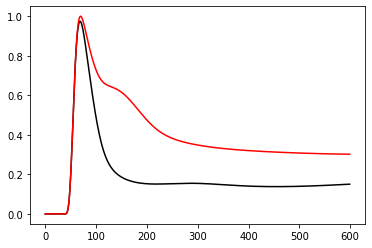

In [87]:
mean_act_v1 = np.array(V1["mean"])
mean_act_v4 = np.array(V4["mean"])
# maxV1 = np.amax(mean_act_v1)
# maxV4 = np.amax(mean_act_v4)
# mean_act_v1 /= maxV1
# mean_act_v4 /= maxV4

act_v4 = np.array([mean_act_v4[:,1, 1],
                  mean_act_v4[:,7, 7]])

maxV4 = np.amax(act_v4)
print(maxV4)
f, axs = plt.subplots(1,1)#, figsize=(20,10))
# plt.plot(act_v4.T / maxV4)
axs.plot(act_v4[0] / maxV4, 'k')
axs.plot(act_v4[1] / maxV4, 'r')

(2, 600)
1.0


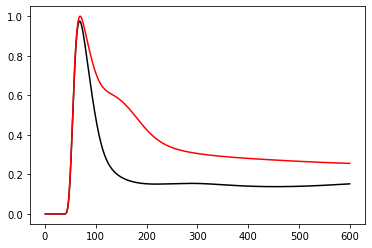

In [77]:
V4_0 = np.genfromtxt('v4_0_matlab.csv', delimiter=',')
V4_1 = np.genfromtxt('v4_1_matlab.csv', delimiter=',')

# V4_0 = V4_0[~np.isnan(V4_0)]
# V4_1 = V4_1[~np.isnan(V4_1)]
# f, axs = plt.subplots(2,1, figsize = (20,10))
plt.plot(V4_0, 'k')
plt.plot(V4_1, 'r')

mean_act_v1 = np.array(V1["mean"])
mean_act_v4 = np.array(V4["mean"])
act_v4 = np.array([mean_act_v4[:,model.V4[0].bck_y, model.V4[0].bck_x],
                  mean_act_v4[:,model.V4[0].cen_y, model.V4[0].cen_x]])
print(act_v4.shape)
maxV4 = np.nanmax([V4_0, V4_1])
print(maxV4)
# f, axs = plt.subplots(1,1)
# # plt.plot(act_v4[1] / maxV4 - (act_v4[0] / maxV4), 'k')
# axs.plot(act_v4[0] / maxV4, 'r')
# axs.plot(act_v4[1] / maxV4, 'r')

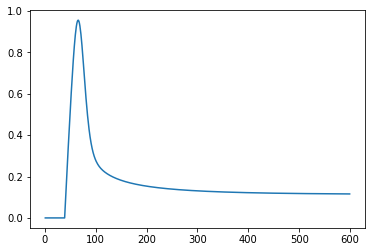

In [6]:
m_lgn_cen = np.genfromtxt('lgn_cen.csv', delimiter=',')
plt.plot(m_lgn_cen)

In [27]:
parm_df

,V1,V2,V4,LGN
c1,1.000000,1.000000,1.0,NaN
c2,1.000000,1.000000,5.0,NaN
c3,5.000000,5.000000,5.0,NaN
c4,15.000000,15.000000,1.0,NaN
e1,5.000000,3.000000,5.0,NaN
e2,1.000000,5.000000,2.0,NaN
e3,35.000000,35.000000,15.0,NaN
e4,2.000000,2.000000,2.0,NaN
e5,2.000000,2.000000,0.0,NaN
g1,45.000000,45.000000,25.0,NaN


In [12]:
space_1D= np.linspace(-1, 1, 5)
X, Y = np.meshgrid(space_1D, space_1D)
X

array([[-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ]])

In [16]:
model.V4[0].cen_y

8

KeyError: 600

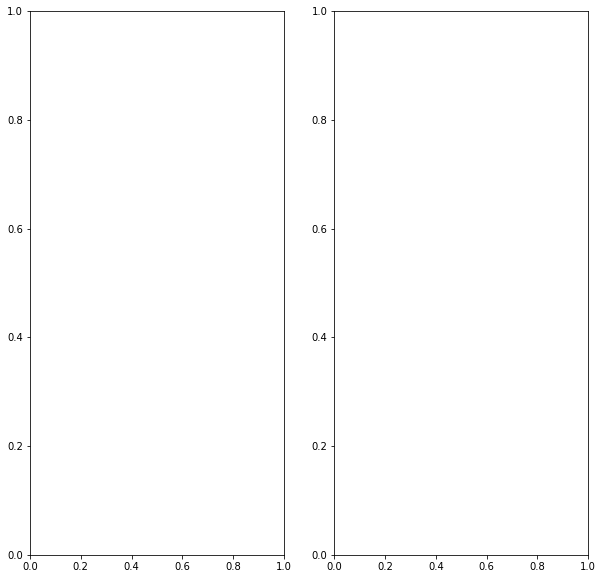

In [44]:
cmap = 'jet'
n=600

f, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(V1[n], cmap=cmap)
axs[1].imshow(V4[n], cmap=cmap)
print(np.array(V4)[n,6:9,6:9])

In [21]:
def norm(x):
#     print(np.max(x))
    return x / np.amax(x)
#     return (x-np.min(x)) / (np.max(x) - np.min(x))



def extract_portions(activity, x_min, x_max, y_min, y_max):
    if y_min == y_max and x_min == x_max:
        center = activity[:,x_min,y_min]
    else:
        center = activity[:,x_min:x_max,y_min:y_max]
    
    bg1 = activity[:,:x_min,:]
    bg2 = activity[:,x_max:,:]
    bg3 = activity[:,x_min:x_max,:y_min]
    bg4 = activity[:,x_min:x_max,y_max:]
    background = [bg1,bg2,bg3,bg4]
    
    if y_min == y_max:
        edge1 = activity[:,x_min-1:x_min,y_min]
        edge2 = activity[:,x_max:x_max+1,y_min]
        edge3 = activity[:,x_min:x_max,y_min]
        edge4 = activity[:,x_min:x_max,y_max]
    else:
        edge1 = activity[:,x_min-1:x_min,y_min:y_max]
        edge2 = activity[:,x_max:x_max+1,y_min:y_max]
        edge3 = activity[:,x_min:x_max,y_min-1:y_min]
        edge4 = activity[:,x_min:x_max,y_max-1:y_max]
    
    edges = [edge1, edge2, edge3, edge4]
    return center, background, edges
    

In [46]:
center_60_1, background_60_1, _ = extract_portions(V4_arr, 2, 3, 3, 3)
center_30_1, background_30_1, _ = extract_portions(V4_arr, 12, 13, 13, 13)

/Users/zach/.virtualenvs/model1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zach/.virtualenvs/model1/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


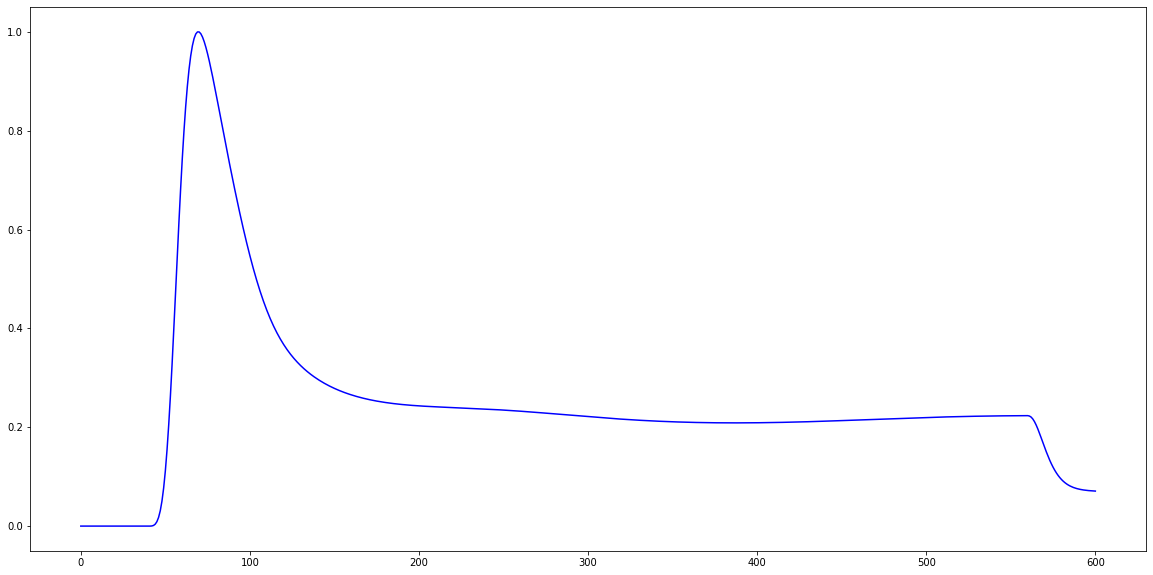

In [24]:
# _V1 = {}
# _V2={}
# _V4={}
# # version = 6
# # for f in range(len(model.features)):
# #     preprocessing[f] = np.load(f"results{version}/preprocessing_{f}.npy")
# #     _V1[f] = np.load(f"results{version}/V1_{f}.npy")
# #     _V2[f] = np.load(f"results{version}/V2_{f}.npy")
# #     _V4[f] = np.load(f"results{version}/V4_{f}.npy")

# version = "1_0"
# # preprocessing["mean"] = np.load(f"results{version}/preprocessing_mean.npy")
# _V1["mean"] = np.load(f"results{version}/V1_mean.npy")
# _V2["mean"] = np.load(f"results{version}/V2_mean.npy")
# _V4["mean"] = np.load(f"results{version}/V4_mean.npy")
# # preprocessing["sum"] = np.load(f"results{version}/preprocessing_sum.npy")
# # _V1["sum"] = np.load(f"results{version}/V1_sum.npy")
# _V2["sum"] = np.load(f"results{version}/V2_sum.npy")
# _V4["sum"] = np.load(f"results{version}/V4_sum.npy")


f, axs = plt.subplots(1,1, figsize=(20,10))

# V1_arr = np.array(V1["mean"])

# na[15:25, 15:17] = 60
# na[96:106, 102:104] = 30
# center, background, edges = extract_portions(V1_arr, 48, 72, 48, 72)
# center, background, edges = extract_portions(V1_arr, 96,106, 102,104)
# V1max = np.max(V1_arr)
# # axs[0].imshow(center[600])
# center_mean = np.mean(center, axis=(1,2))
# bg_mean = np.mean([np.mean(V1_arr, axis=(1,2)) for bg in background], axis=0)
# edge_mean = np.mean([np.mean(edge, axis=(1,2)) for edge in edges], axis=0)

# axs[0].plot((center_mean / V1max), 'b', label='center')
# axs[0].plot((bg_mean / V1max), 'k', label='background')
# axs[0].plot((edge_mean / V1max), 'r', label='edge')
# axs[0].legend()
# axs[0].title.set_text("Activity across V1")

V4_arr = np.array(V4["mean"])
# center = V4_arr[:, model.V4[0].cen_x, model.V4[0].cen_y]
# # center.shape
# center /= np.max(center)
# background = V4_arr[:, model.V4[0].bck_x, model.V4[0].bck_y]
# background /= np.max(background)

# axs.plot(center, 'b', label="center")
# axs.plot(background, 'r', label="background")


center, background, edges = extract_portions(V4_arr, 8, 8, 8, 8)
# print(center)
center, background, edges = extract_portions(V4_arr, 2, 2, 2, 2)
# # print(V4_arr[:,2:3,2])
# center_mean = np.mean(center, axis=(1,2))
# # print(center.shape)
bg_mean = np.mean([np.mean(bg, axis=(1,2)) for bg in background], axis=0)
# # edge_mean = np.mean([np.mean(edge, axis=(1,2)) for edge in edges], axis=0)


# center_1_probe = np.mean(V4_arr[:,2:3,2:3], axis=(1,2)) / np.max(V4_arr)
# plt.plot(center_1_probe)
# center_2_probe = np.mean(V4_arr[:,12:13,12:13], axis=(1,2)) / np.max(V4_arr)
# bg_probe = V4_arr[:,7,7] / np.max(V4_arr)

# axs[1].plot(norm(center_mean[:,0]) - norm(bg_mean), 'b', label='0')
axs.plot(norm(center), 'b', label='center')
axs.plot(norm(bg_mean), 'k', label='background')
# # axs[1].plot((edge_mean / V4max), 'r', label='edge')
# axs[0].legend()
# axs[0].title.set_text("Activity across V4 44 degree block")


# center, background, edges = extract_portions(V4_arr, 6, 9, 6, 9)
# # print(V4_arr[:,2:3,2])
# center_mean = np.mean(V4_arr[:,6:9,6:9], axis=(1,2))
# bg_mean = np.mean([np.mean(bg, axis=(1,2)) for bg in background], axis=0)
# edge_mean = np.mean([np.mean(edge, axis=(1,2)) for edge in edges], axis=0)

# print(np.mean(V4_arr[:,6:9,6:9]/np.max(V4_arr), axis=(1,2))[600])
# axs[1].plot((center_mean)/V4max, 'b', label='center')
# axs[1].plot((bg_mean)/V4max, 'k', label='background')
# # axs[1].plot(norm(edge_mean), 'r', label='edge')
# axs[1].legend()
# axs[1].title.set_text(f"Activity across V4 90 degree block")


# V1_arr = np.array(_V1["sum"])

# center, background, edges = extract_portions(V1_arr, 48, 72, 48, 72)

# center_mean = np.mean(center, axis=(1,2))
# bg_mean = np.sum([np.mean(bg, axis=(1,2)) for bg in background], axis=0)
# edge_mean = np.sum([np.mean(edge, axis=(1,2)) for edge in edges], axis=0)

# axs[1,0].plot(norm(center_mean), 'b', label='center')
# axs[1,0].plot(norm(bg_mean), 'k', label='background')
# axs[1,0].plot(norm(edge_mean), 'r', label='edge')
# axs[1,0].legend()


# V4_arr = norm(np.array(_V4["sum"]))
# center, background, edges = extract_portions(V4_arr, 6, 9, 6, 9)
# center_mean = np.mean(center, axis=(1,2))
# bg_mean = np.mean([np.mean(bg, axis=(1,2)) for bg in background], axis=0)
# edge_mean = np.mean([np.mean(edge, axis=(1,2)) for edge in edges], axis=0)


# axs[1,1].plot(norm(center_mean), 'b', label='center')
# axs[1,1].plot(norm(bg_mean), 'k', label='background')
# axs[1,1].plot(norm(edge_mean), 'r', label='edge')
# axs[1,1].legend()

In [49]:
center_60_2, background_60_2, _ = extract_portions(V4_arr, 2, 3, 3, 3)
center_30_2, background_30_2, _ = extract_portions(V4_arr, 12, 13, 13, 13)

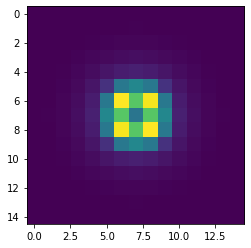

In [26]:
plt.imshow(np.mean( np.array([ model.V4[f].V for f in range(len(model.features))]), axis=0 ))

In [66]:
import math
na = generate_block()

Stimulus = np.tile(0,[121, 121, 2])
Stimulus[:,:,0] = na
Stimulus[:,:,1] = 1-na

StimulusSeq = np.zeros((121, 121, 2, 2))
StimulusSeq[:,:,:,0] = Stimulus
StimulusSeq[:,:,:,1] = np.zeros((121, 121, 2))
IndexSeq = np.tile(2,[1,40]) #...
#             repmat(1,1,stimulusIterNum) ...
#             repmat(2,1,postIterNum)];
IndexSeq

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [25]:
mean_activity_v1 = model.V1_trace
mean_activity_v4 = np.array(model.V4_trace)[:,:2]
print(mean_activity_v4.shape)
maxV1 = np.max(mean_activity_v1)
maxV4 = np.max(mean_activity_v4)
mean_activity_v1 /= maxV1
mean_activity_v4 /= maxV4
# mean_activity_v4[:,0] /= np.max(mean_activity_v4[:,0])
# mean_activity_v4[:,1] /= np.max(mean_activity_v4[:,1])

slice_activity_v1 = model.V1_slice / maxV1
slice_activity_v4 = model.V4_slice / maxV4

offsetRfV1 = int(model.V1[0].input_dim / 6)
offsetRfV4 = int(model.V4[0].input_dim / 6)

rfLen = 1;

plt.plot(mean_activity_v4, label=['background', 'center'])
plt.legend()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [18]:
version = "small_diff"

Path(f"results{version}").mkdir(parents=True, exist_ok=True)
# for f in model.features:
#     np.save(f"results{version}/preprocessing_{f}.npy", preprocessing[f])
#     np.save(f"results{version}/V1_{f}.npy", V1[f])
#     np.save(f"results{version}/V2_{f}.npy", V2[f])
#     np.save(f"results{version}/V4_{f}.npy", V4[f])

np.save(f"results{version}/preprocessing_mean.npy", preprocessing["mean"])
np.save(f"results{version}/V1_mean.npy", V1["mean"])
np.save(f"results{version}/V2_mean.npy", V2["mean"])
np.save(f"results{version}/V4_mean.npy", V4["mean"])
# np.save(f"results{version}/preprocessing_sum.npy", preprocessing["sum"])
# np.save(f"results{version}/V1_sum.npy", V1["sum"])
# np.save(f"results{version}/V2_sum.npy", V2["sum"])
# np.save(f"results{version}/V4_sum.npy", V4["sum"])

In [6]:
np.array(V1["mean"]).shape

(601, 121, 121)

In [36]:
model.V1[0].bck_x

20

In [17]:
center, bg, egdes = extract_portions(np.array(V4["mean"]), 6, 9, 6, 9)
np.mean(V4["mean"][600])

0.41039682145593903